In [520]:
import pandas as pd
import numpy as np
import IPython.display as Disp

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder,OrdinalEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [20]:
from hyperopt.early_stop import no_progress_loss

from hyperopt import tpe,hp,Trials,space_eval
from hyperopt.fmin import fmin

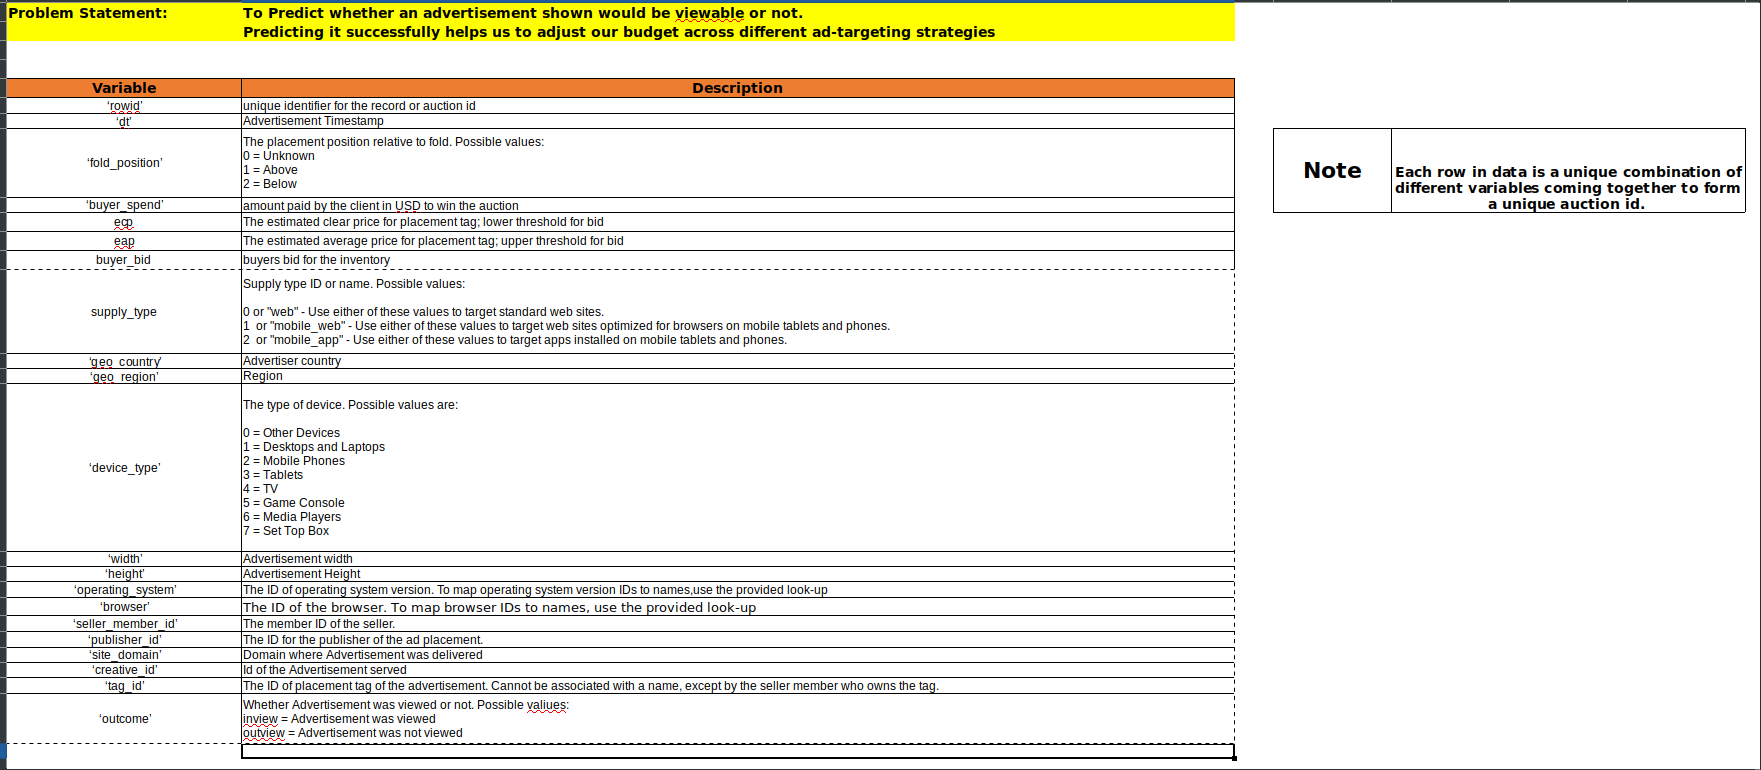

* no lookup  up table provided multiple feature can be combined 

In [8]:
train_data = pd.read_csv("train.csv",index_col="rowid",parse_dates=[1],dtype={"fold_position":"category","supply_type":"category",\
                                                                   "geo_country":"category","device_type":"category",\
                                                                   "site_domain":"category","operating_system":"category",\
                                                                   "browser":"category","seller_member_id":"category",\
                                                                   "publisher_id":"category","creative_id":"category", "tag_id":"category",\
                                                                    "outcome":"category","geo_region":"category"})

train_data["is_wday"] = train_data['dt'].apply(lambda x : x.dayofweek//5==1)

In [535]:
numeric_columns = [ 'buyer_spend', 'ecp', 'eap','buyer_bid','width','height']
categorical_columns = ["fold_position","supply_type","geo_country","device_type",\
                       "site_domain","operating_system","browser","seller_member_id",\
                       "publisher_id","creative_id", "tag_id","geo_region","is_wday"]
target_columns = ["outcome"]

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254919 entries, id1 to id1709396985210
Data columns (total 21 columns):
dt                  254919 non-null datetime64[ns]
fold_position       254919 non-null category
buyer_spend         254919 non-null float64
ecp                 254919 non-null float64
eap                 254919 non-null float64
buyer_bid           254919 non-null float64
supply_type         254919 non-null category
geo_country         254919 non-null category
geo_region          254919 non-null category
device_type         254919 non-null category
width               254919 non-null int64
height              254919 non-null int64
operating_system    254919 non-null category
browser             254919 non-null category
seller_member_id    254919 non-null category
publisher_id        254919 non-null category
site_domain         254919 non-null category
creative_id         254919 non-null category
tag_id              254919 non-null category
outcome             254919 non-n

In [49]:
train_data.isnull().sum()

dt                  0
fold_position       0
buyer_spend         0
ecp                 0
eap                 0
buyer_bid           0
supply_type         0
geo_country         0
geo_region          0
device_type         0
width               0
height              0
operating_system    0
browser             0
seller_member_id    0
publisher_id        0
site_domain         0
creative_id         0
tag_id              0
outcome             0
dtype: int64

* no data is missing

In [37]:
train_data.head()

,dt,fold_position,buyer_spend,ecp,eap,buyer_bid,supply_type,geo_country,geo_region,device_type,width,height,operating_system,browser,seller_member_id,publisher_id,site_domain,creative_id,tag_id,outcome
rowid,,,,,,,,,,,,,,,,,,,,
id1,2019-12-20 14:42:49,0,0.69822,4.68,1.20,0.706165,0,GB,B9,1,300,250,137,8,459,1575138,menchtech.com,189215222,17045914,inView
id10,2019-12-18 14:07:29,0,0.66697,2.18,0.51,0.719714,1,GB,T7,2,300,250,156,8,459,1575138,lifelistener.com,189215222,17045914,outView
id100,2019-12-21 17:55:25,1,6.52632,4.65,2.60,13.023892,1,GB,M9,2,300,250,195,8,1410,1466317,leicestermercury.co.uk,189215439,15296302,inView
id1000,2019-12-28 23:27:53,1,0.70175,3.87,1.68,0.705483,1,GB,B4,2,300,250,228,8,1410,1494173,dailyforest.com,189215222,15791166,outView
id1001,2019-12-24 09:16:01,1,13.55601,4.44,1.80,15.566229,1,GB,J8,2,300,250,195,8,181,764570,sportbible.com,189215439,6933617,inView


In [10]:
train_data.describe(include="category")

,fold_position,supply_type,geo_country,geo_region,device_type,operating_system,browser,seller_member_id,publisher_id,site_domain,creative_id,tag_id,outcome
count,254919,254919,254919,254919,254919,254919,254919,254919,254919,254919,254919,254919,254919
unique,3,2,1,217,3,92,24,52,1088,3026,30,5007,2
top,0,0,GB,G5,1,137,8,1410,1575138,carnovels.com,189215222,0,inView
freq,121791,147018,254919,6103,146812,108349,182656,96061,32756,21236,118361,31831,138979


* there are few categories like fold position , supply type, geo_country, device_type which seems to have very low unique values which may be not usefull, we will evaluate the interaction later
* classes are well balanced

In [40]:
train_data.describe()

,buyer_spend,ecp,eap,buyer_bid,width,height
count,254919.000000,254919.000000,254919.000000,254919.000000,254919.000000,254919.000000
mean,3.872979,5.246222,1.215563,5.839485,377.335522,261.880519
std,5.741004,4.545245,1.265621,8.668829,184.355472,137.231100
min,0.012060,0.010000,0.010000,0.310269,120.000000,90.000000
25%,0.685050,2.820000,0.680000,0.705483,300.000000,250.000000
50%,0.708560,3.870000,0.900000,0.733476,300.000000,250.000000
75%,5.991830,5.980000,1.290000,13.000019,300.000000,250.000000
max,42.736210,40.000000,40.000000,44.873013,970.000000,600.000000


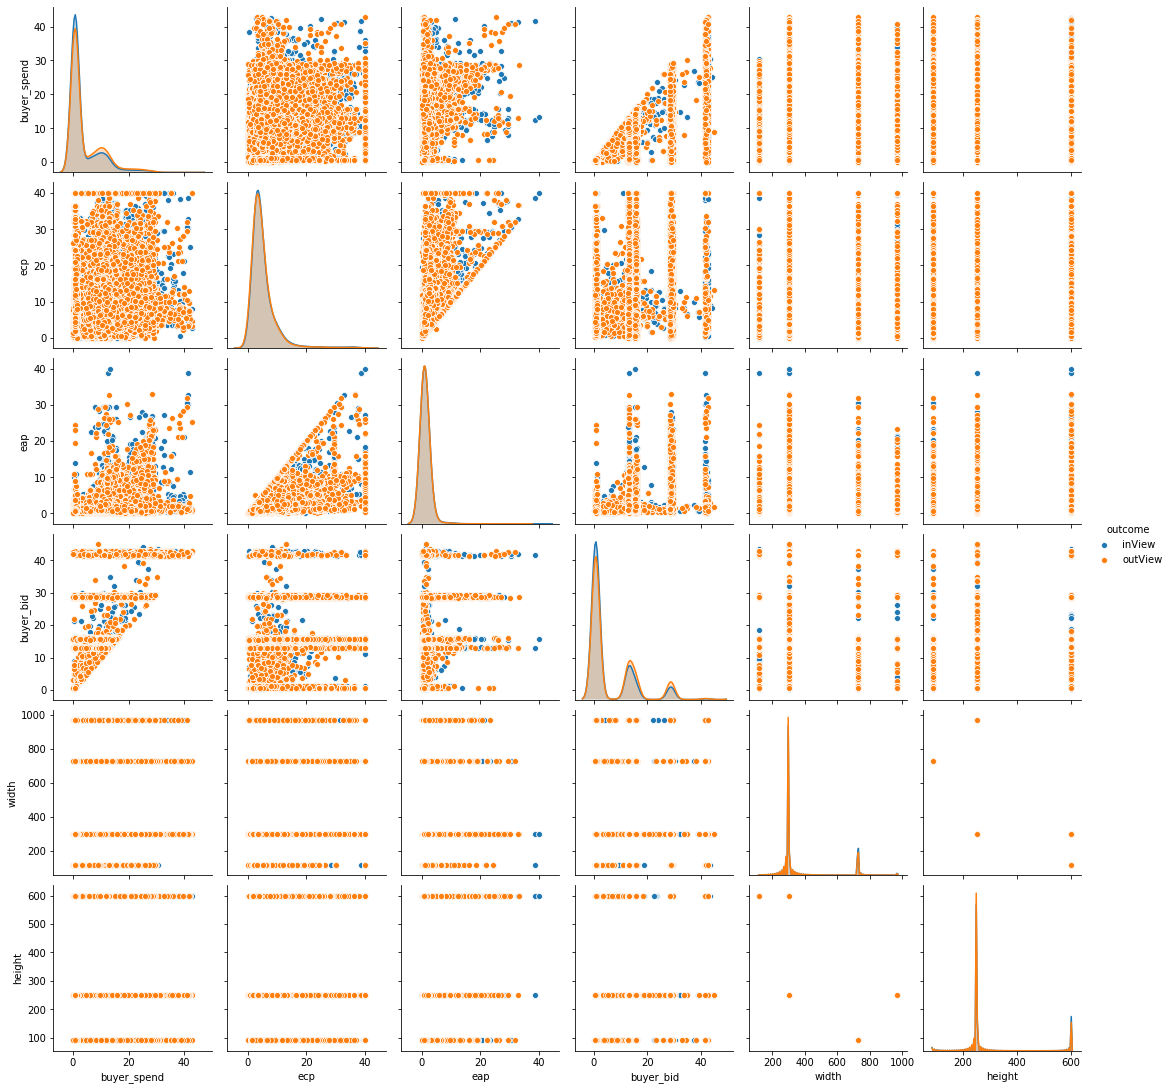

In [10]:
sns.pairplot(train_data[numeric_columns+target_columns], hue='outcome',kind="scatter",grid_kws={'bw':1.5})


* width, height and buyer_bid are continous quantity buy they have very fix number values
* no separation is visible from density plot
* skewness is there

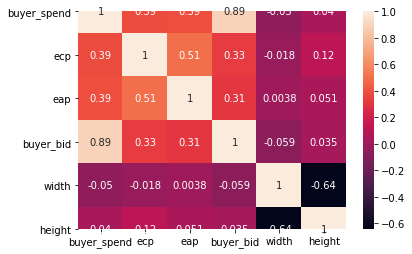

In [17]:
sns.heatmap(train_data[numeric_columns].corr(),annot=True)

* buyer_bid and buyer_spend are highly correlated

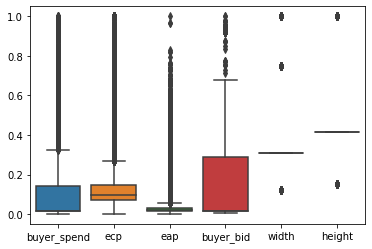

In [41]:
sns.boxplot(data =train_data[numeric_columns]/(train_data[numeric_columns].max()))

* good amount of outliers are there (width and height are generally constant/categorical)

In [29]:
# train_data["outcome"] = train_data["outcome"].cat.rename_categories([0,1])
# #["inview","outview"] --> [0,1]

In [65]:
sample_data = train_data.sample(frac=.4)

In [66]:
ct = ColumnTransformer([("ordinal", OrdinalEncoder(), categorical_columns),\
                        ("Scaler", StandardScaler(), numeric_columns)], remainder = 'drop')

X = ct.fit_transform(sample_data)

lab_enc = LabelEncoder()

y = lab_enc.fit_transform(sample_data[target_columns])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


* recursive feature elimination

In [67]:
# clf = SVC(kernel="linear",class_weight="balanced")
clf = LogisticRegression(class_weight="balanced",max_iter=1000)
# The "accuracy" scoring is proportional to the number of correct
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(2),
              scoring="accuracy",n_jobs=-1,verbose=1)
rfecv.fit(X, y)
Disp.display(pd.DataFrame({"feature_name":categorical_columns+numeric_columns,"Ranking":rfecv.ranking_,"Support":rfecv.support_}).sort_values("Ranking"))

Fitting estimator with 19 features.


/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 18 features.


/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

,feature_name,Ranking,Support
0,fold_position,1,True
16,buyer_bid,1,True
15,eap,1,True
14,ecp,1,True
13,buyer_spend,1,True
12,is_wday,1,True
11,geo_region,1,True
17,width,1,True
9,creative_id,1,True
7,seller_member_id,1,True


* buyer spend and eap are considered high in ranking

In [ ]:
clf = SVC(kernel="linear",class_weight="balanced",cache_size=7000)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10),
              scoring="accuracy",n_jobs=-1,verbose=1)
rfecv.fit(X, y)

Disp.display(pd.DataFrame({"feature_name":sample_data.columns[1:-1].tolist(),"Ranking":rfecv.ranking_,"Support":rfecv.support_}).sort_values("Ranking"))

In [68]:
clf = RandomForestClassifier(n_jobs=-1,oob_score=True)
clf.fit(X,y)

RandomForestClassifier(n_jobs=-1, oob_score=True)

In [71]:
clf.oob_score_

0.6471442021026205

In [70]:
Disp.display(pd.DataFrame({"feature_name":categorical_columns+numeric_columns,"score":clf.feature_importances_}).sort_values("score",ascending=False))

,feature_name,score
11,geo_region,0.216484
13,buyer_spend,0.143511
15,eap,0.121596
14,ecp,0.112238
16,buyer_bid,0.090604
4,site_domain,0.052753
10,tag_id,0.051261
5,operating_system,0.047488
8,publisher_id,0.037740
9,creative_id,0.031341


#### **building models**

In [10]:
#based on importance and features selection
numeric_columns_filt = ["buyer_spend","eap","ecp"] #based on importance and features selection
categorical_columns_filt = ["geo_region","site_domain","tag_id","operating_system","publisher_id","creative_id","browser","seller_member_id","is_wday"]

In [11]:
#remove extreme_data
train_data_filt = train_data[(train_data[numeric_columns]<train_data[numeric_columns_filt].quantile(.95)).any(axis=1)] 
train_data_filt = train_data_filt[(train_data_filt[numeric_columns]>train_data_filt[numeric_columns_filt].quantile(.05)).any(axis=1)] 
       

In [12]:
ct = ColumnTransformer([("onehot", OneHotEncoder(), categorical_columns_filt),\
                        ("Scaler", StandardScaler(), numeric_columns_filt)], remainder = 'drop')

X = ct.fit_transform(train_data_filt)
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(train_data_filt[target_columns])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [94]:
clf = RandomForestClassifier(n_jobs=-1,oob_score=True)
clf.fit(X,y)

RandomForestClassifier(n_jobs=-1, oob_score=True)

In [95]:
clf.oob_score_

0.6650910211921681

In [96]:
### lets tune parameters

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.9,random_state=42)
params={'n_estimators':hp.choice("n_estimators",list(range(5,100,20))+list(range(100,1000,100))+list(range(1000,5000,500))),
       'max_depth':hp.choice("max_depth",list(range(5,40,5))),
       'min_samples_leaf':hp.choice('min_samples_leaf',list(range(1,6))),
       'min_samples_split':hp.choice('min_samples_split',list(range(2,6)))}

In [15]:
seed=2
def objective(params):
    print(params)
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    clf=RandomForestClassifier(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred) 
    return 1-acc

def optimize(trial):

    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=500,\
              rstate=np.random.RandomState(seed),early_stop_fn=no_progress_loss(iteration_stop_count=20,percent_increase=.2))
    return best

trial=Trials()
best=optimize(trial)



{'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 3500}
{'max_depth': 35, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 25}  
{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 2000}
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}
{'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
{'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200} 
{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 45}  
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2500}
{'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 400}
{'max_depth': 35, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 4500}
  2%|▏         | 10/500 [20:19<28:50:17, 211.87s/trial, best loss: 0.34254209153426607]


In [26]:
space_eval(params,best)

{'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

#### **light GBM**

In [30]:
clf = LGBMClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test,y_pred) 
print(acc)

0.662595842225911


In [156]:
params = {
        #this is just piling on most of the possible parameter values for LGBM
        #some of them apparently don't make sense together, but works for now.. :)
        'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart','goss']),
        'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'bin_construct_sample_cnt': hp.quniform('bin_construct_sample_cnt', 20000, 200000, 20000),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'n_estimators':hp.quniform('n_estimators', 20, 1000, 50)
    }

In [158]:
seed=2
def objective(params):
#     print(params)
    boosting_type = params['boosting_type']
    num_leaves = int(params['num_leaves'])
    learning_rate = float(params['learning_rate'])
    bin_construct_sample_cnt = int(params['bin_construct_sample_cnt'])
    feature_fraction = float(params['feature_fraction'])
    bagging_fraction = float(params['bagging_fraction'])
    min_data_in_leaf = int(params['min_data_in_leaf'])
    lambda_l1 = float(params['lambda_l1'])
    lambda_l2 = float(params['lambda_l2'])
    min_child_weight = float(params['min_child_weight'])
    n_estimators = int(params['n_estimators'])
    
    clf=LGBMClassifier(n_estimators=n_estimators,boosting_type=boosting_type,num_leaves=num_leaves,learning_rate=learning_rate,\
                       bin_construct_sample_cnt=bin_construct_sample_cnt,feature_fraction=feature_fraction,bagging_fraction=bagging_fraction,\
                       min_data_in_leaf=min_data_in_leaf,lambda_l1=lambda_l1,lambda_l2=lambda_l2,min_child_weight=min_child_weight)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred) 
    return 1-acc

def optimize(trial):

    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=1000,\
              rstate=np.random.RandomState(seed),early_stop_fn=no_progress_loss(iteration_stop_count=100,percent_increase=.2))
    return best

trial=Trials()
best=optimize(trial)

 17%|█▋        | 172/1000 [4:37:48<6:47:40, 29.54s/trial, best loss: 0.3200537506916449]  


In [159]:
space_eval(params,best)

{'bagging_fraction': 0.8032046682475807,
 'bin_construct_sample_cnt': 100000.0,
 'boosting_type': 'dart',
 'feature_fraction': 0.5884022425253095,
 'lambda_l1': 7.04954605624188e-05,
 'lambda_l2': 0.007209514310122227,
 'learning_rate': 0.12547137229048516,
 'min_child_weight': 4.3585206685403205e-06,
 'min_data_in_leaf': 1.0,
 'n_estimators': 850.0,
 'num_leaves': 134.0}

In [162]:
print("best accuract = {}".format(1-min(trial.losses())))

best accuract = 0.6799462493083551


##### accuracy is limited to 68%

## Deeper dive in data

In [167]:
for col in categorical_columns:
    print(col+"-->",np.unique(train_data[col]))

fold_position--> ['0' '1' '2']
supply_type--> ['0' '1']
geo_country--> ['GB']
device_type--> ['1' '2' '3']
site_domain--> ['1000rr.co.uk' '1001freefonts.com' '101greatgoals.com' ...
 'zimbabwesituation.com' 'zoopla.co.uk' 'zoznam.sk']
operating_system--> ['0' '100' '101' '113' '114' '119' '124' '125' '129' '130' '134' '136'
 '137' '138' '139' '141' '142' '143' '147' '148' '150' '151' '154' '155'
 '156' '157' '160' '161' '162' '164' '166' '168' '169' '170' '171' '172'
 '173' '174' '175' '176' '177' '178' '179' '180' '181' '184' '185' '187'
 '190' '191' '193' '195' '198' '200' '203' '206' '211' '217' '218' '226'
 '227' '228' '233' '236' '237' '239' '240' '241' '242' '243' '244' '247'
 '249' '250' '251' '252' '253' '39' '40' '41' '46' '52' '55' '80' '81'
 '82' '83' '90' '91' '92' '93' '99']
browser--> ['0' '10' '11' '13' '14' '17' '18' '19' '20' '21' '22' '24' '26' '27' '28'
 '29' '39' '4' '40' '5' '6' '7' '8' '9']
seller_member_id--> ['1001' '1019' '1226' '1354' '1410' '181' '2542' '2678

In [582]:
os_lookup = pd.read_excel("Viewability Description.xlsx",sheet_name = "OS Lookup",index_col=0)
for i in train_data["operating_system"].unique():
    if int(i) not in os_lookup.index:
        os_lookup.loc[int(i)] = ["Unknown","Unknown"]
        
## setting unavailable information as unknown        

browser_lookup = pd.read_excel("Viewability Description.xlsx",sheet_name = "Browser Lookup",index_col=0)
for i in train_data["browser"].unique():
    if int(i) not in browser_lookup.index:
        browser_lookup.loc[int(i)] = ["Unknown","Unknown"]

In [583]:
os_lookup

,OS,OS Version
OS code,,
15,Android,Android 2.2 Froyo
16,Android,Android 2.2.1 Froyo
17,Android,Android 2.2.2 Froyo
18,Android,Android 2.2.3 Froyo
19,Android,Android 2.3 Gingerbread
...,...,...
191,Unknown,Unknown
174,Unknown,Unknown
241,Unknown,Unknown


* there are multiple unknown os in the information table only one row is defined as unknown

In [169]:
import validators

* fold_position 0 is Unknown


* invalid site domains
* checking all invalid data shows result is due to wrong definition

In [188]:
train_data.site_domain.str.split(pat = ".")train_data.site_domain.str.split(pat = ".")

rowid
id1                            [menchtech, com]
id10                        [lifelistener, com]
id100                [leicestermercury, co, uk]
id1000                       [dailyforest, com]
id1001                        [sportbible, com]
                               ...             
id1709396985205            [universityfox, com]
id1709396985206               [allrecipes, com]
id1709396985207                 [metro, co, uk]
id1709396985208                  [gumtree, com]
id1709396985210    [tabs, ultimate-guitar, com]
Name: site_domain, Length: 254919, dtype: object

In [212]:
# new valiable is top domain is .com ,.uk etc
train_data["domain_top"] = train_data.site_domain.apply(lambda x: x.split(".")[-1].split("/")[0])

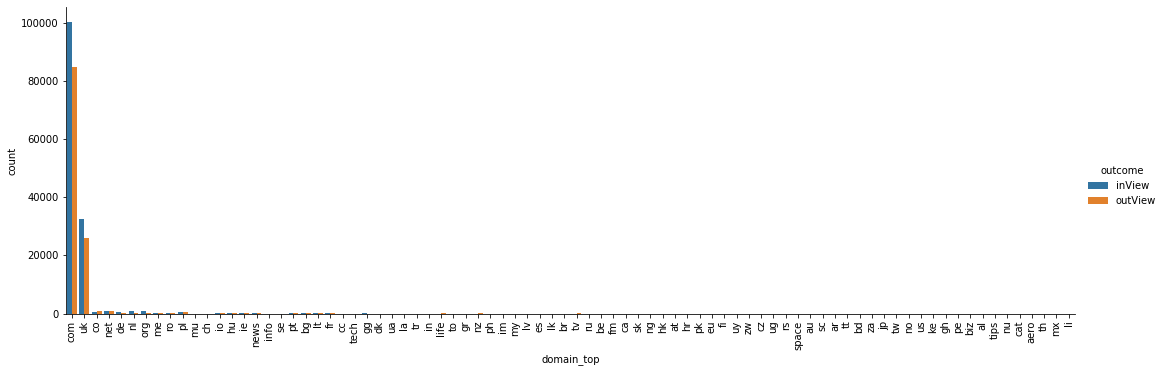

In [346]:
g = sns.catplot(x="domain_top",data=train_data,hue="outcome",kind="count",aspect=3)
g.set_xticklabels(rotation=90)


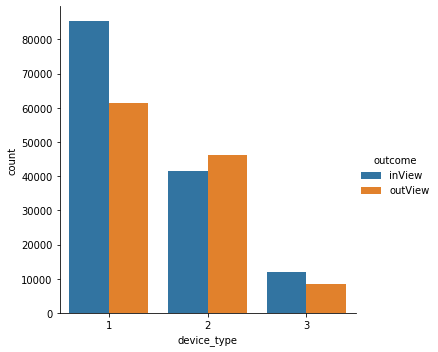

In [211]:
device_types = ["Other Devices","Desktops and Laptops","Mobile Phones","Tablets","TV","Game Console","Media Players","Set Top Box"]

device_type_dict = dict(zip(range(len(device_types)),device_types))

sns.catplot(x="device_type",data=train_data,hue="outcome",kind="count")

* outcome cannot be judged from device_type only

In [214]:
#mobile, laptop and desktop, tablets , gameconsole are handheld other are not advertisement cannot be controlled by hand
#additionally apps can be installed here

In [275]:
train_data["main_os"] = train_data.operating_system.apply(lambda x: os_lookup.loc[int(x),"OS"])

train_data.pivot_table(index="main_os",columns="outcome",aggfunc="size",fill_value=0)

outcome,inView,outView
main_os,,
Android,907,808
Apple Mac,91,65
Apple iOS,80,27
Linux,343,204
Microsoft Windows,61894,46455
Unknown,62161,59571
Windows 7,10280,6696
Windows 8,180,108
Windows 8.1,2897,1887


* there are good amount of columns whose browser info is unknown

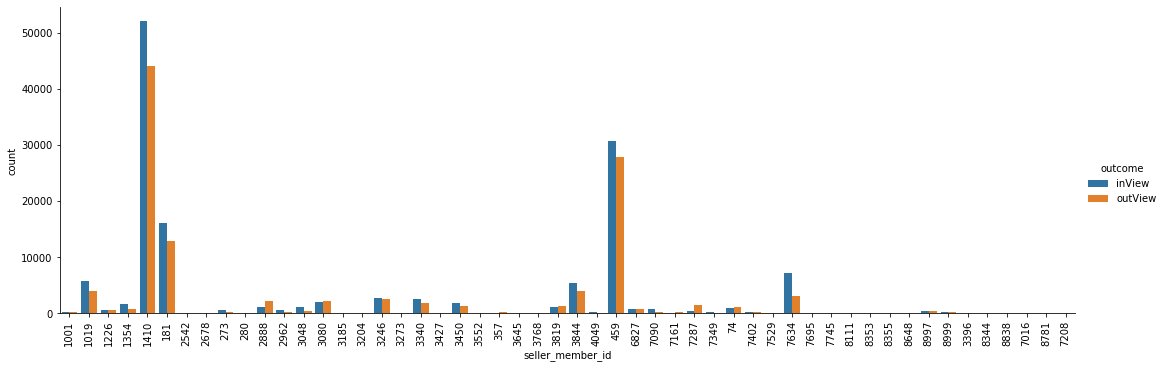

In [272]:
g = sns.catplot(x="seller_member_id",data=train_data,hue="outcome",kind="count",aspect=3)
g.set_xticklabels(rotation=90)


In [301]:
 train_data[train_data.publisher_id.apply(lambda x: not validators.length(x,5,8))]["publisher_id"].unique()

[0]
Categories (1, object): [0]

In [347]:
df = train_data.pivot_table(index="publisher_id",columns="outcome",aggfunc="size",fill_value=0).sort_values("inView",ascending=False)


(df.inView/(df.outView+1)).sort_values(ascending=False)

publisher_id
1465975    54.0
1468787    26.0
591842     14.4
263106     10.0
737422      8.5
           ... 
762610      0.0
367002      0.0
762605      0.0
1601643     0.0
761590      0.0
Length: 1088, dtype: float64

In [322]:
(df.outView/(df.inView+1)).sort_values(ascending=False)

publisher_id
1480237    33.800000
1388052    33.000000
1576173    22.000000
1627616    21.666667
780054     19.000000
             ...    
768443      0.000000
1527754     0.000000
763907      0.000000
1518295     0.000000
1575692     0.000000
Length: 1088, dtype: float64

In [325]:
(df.inView-df.outView).abs().sort_values(ascending=False)

publisher_id
1468646    10256
1468664     5216
1575138     4336
1566298     3136
1575733     2735
           ...  
1155039        0
1419381        0
1173130        0
763160         0
852884         0
Length: 1088, dtype: int64

* publisher id is number from 5 to 7 except **0**, its seems like **0** is vague or missing value
* categories with highest ratio inview and outview w.r.t. each other
* there are categories with big separation in categories

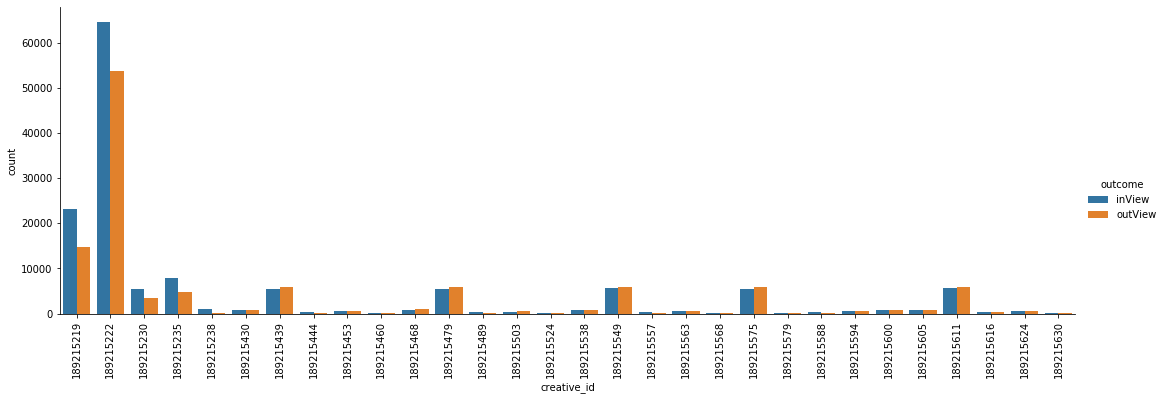

In [332]:
g = sns.catplot(x="creative_id",data=train_data,hue="outcome",kind="count",aspect=3)
g.set_xticklabels(rotation=90)


In [337]:
 train_data[train_data.tag_id.apply(lambda x: not validators.length(x,4,8))]["tag_id"].unique()

[0]
Categories (1, object): [0]

In [335]:
df = train_data.pivot_table(index="tag_id",columns="outcome",aggfunc="size",fill_value=0).sort_values("inView",ascending=False)


* tag_id is number from 4 to 7 except **0**, its seems like **0** is vague or missing value


In [342]:
train_data["region_alpha"]= train_data.geo_region.apply(lambda x: x[0])
train_data["region_num"]= train_data.geo_region.apply(lambda x: x[1])

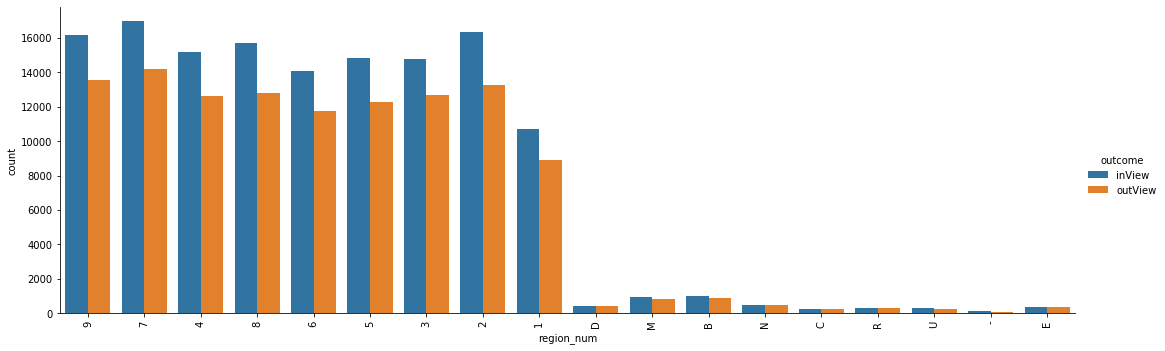

In [345]:
g = sns.catplot(x="region_num",data=train_data,hue="outcome",kind="count",aspect=3)
g.set_xticklabels(rotation=90)


* georegion is alphanumeric except **--**, its seems like **--** is vague or missing value
* georegion with second place as alphabate are not usable


#### check **feature importance**

In [372]:
categorical_columns_1 = categorical_columns + ["main_os","region_alpha","region_num","domain_top"]

In [373]:
ct = ColumnTransformer([("ordinal", OrdinalEncoder(), categorical_columns_1),\
                        ("Scaler", StandardScaler(), numeric_columns)], remainder = 'drop')
X = ct.fit_transform(train_data)
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(train_data[target_columns])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [374]:
clf = RandomForestClassifier(n_jobs=-1,oob_score=True)
clf.fit(X,y)

RandomForestClassifier(n_jobs=-1, oob_score=True)

In [375]:
Disp.display(pd.DataFrame({"feature_name":categorical_columns_1+numeric_columns,"score":clf.feature_importances_}).sort_values("score",ascending=False))

,feature_name,score
17,buyer_spend,0.136102
11,geo_region,0.117777
19,eap,0.105799
18,ecp,0.097406
14,region_alpha,0.085261
15,region_num,0.081098
20,buyer_bid,0.080011
4,site_domain,0.046900
10,tag_id,0.045933
8,publisher_id,0.034307


In [455]:
numerical_columns_filt = ["eap","ecp","buyer_spend"]
categorical_feature_filt = ["region_alpha","region_num"]#,"tag_id","publisher_id","creative_id","operating_system","browser","seller_member_id","is_wday"]

In [460]:
train_data_filt = train_data[(train_data.tag_id!="0") & (train_data.region_alpha!="-") &( train_data.publisher_id!="0") &( train_data.browser!="Unknown") ]

In [445]:
#remove extreme_data
train_data_filt = train_data[(train_data[numeric_columns]<train_data[numeric_columns_filt].quantile(.95)).any(axis=1)] 
train_data_filt = train_data_filt[(train_data_filt[numeric_columns]>train_data_filt[numeric_columns_filt].quantile(.05)).any(axis=1)] 


In [461]:
ct = ColumnTransformer([("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_columns_filt),\
                        ("Scaler", StandardScaler(), numeric_columns_filt)], remainder = 'drop')

X = ct.fit_transform(train_data_filt)
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(train_data_filt[target_columns])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [462]:
#setting all old params
params = {'max_depth': 35,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}
clf.set_params(**params)

clf.fit(X,y)

RandomForestClassifier(max_depth=35, min_samples_split=4, n_jobs=-1,
                       oob_score=True)

In [463]:
clf.oob_score_

0.6630050595665279

* finetuning **LIGHTGBM**

In [465]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.9,random_state=42)

params = {
        #this is just piling on most of the possible parameter values for LGBM
        #some of them apparently don't make sense together, but works for now.. :)
        'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart','goss']),
        'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'bin_construct_sample_cnt': hp.quniform('bin_construct_sample_cnt', 20000, 200000, 20000),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1), #alias "subsample"
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'n_estimators':hp.quniform('n_estimators', 20, 1000, 50)
    }


seed=2
def objective(params):
#     print(params)
    boosting_type = params['boosting_type']
    num_leaves = int(params['num_leaves'])
    learning_rate = float(params['learning_rate'])
    bin_construct_sample_cnt = int(params['bin_construct_sample_cnt'])
    feature_fraction = float(params['feature_fraction'])
    bagging_fraction = float(params['bagging_fraction'])
    min_data_in_leaf = int(params['min_data_in_leaf'])
    lambda_l1 = float(params['lambda_l1'])
    lambda_l2 = float(params['lambda_l2'])
    min_child_weight = float(params['min_child_weight'])
    n_estimators = int(params['n_estimators'])
    
    clf=LGBMClassifier(n_estimators=n_estimators,boosting_type=boosting_type,num_leaves=num_leaves,learning_rate=learning_rate,\
                       bin_construct_sample_cnt=bin_construct_sample_cnt,feature_fraction=feature_fraction,bagging_fraction=bagging_fraction,\
                       min_data_in_leaf=min_data_in_leaf,lambda_l1=lambda_l1,lambda_l2=lambda_l2,min_child_weight=min_child_weight)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred) 
    return 1-acc

def optimize(trial):

    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=1000,\
              rstate=np.random.RandomState(seed),early_stop_fn=no_progress_loss(iteration_stop_count=10,percent_increase=.2))
    return best

trial=Trials()
best=optimize(trial)

  2%|▏         | 18/1000 [06:00<8:59:49, 32.98s/trial, best loss: 0.3252298721686476] 


In [466]:
print(space_eval(params,best))

{'bagging_fraction': 0.8183703076598786, 'bin_construct_sample_cnt': 20000.0, 'boosting_type': 'gbdt', 'feature_fraction': 0.7387163626329092, 'lambda_l1': 0.011593360827482723, 'lambda_l2': 0, 'learning_rate': 0.13970764565478, 'min_child_weight': 0.24349891787273004, 'min_data_in_leaf': 5.0, 'n_estimators': 700.0, 'num_leaves': 45.0}


In [468]:
print((1-min(trial.losses())))

0.6747701278313524


* Finetuning **XGB**

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.9,random_state=42)

params = {
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 50),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.05),
        'max_depth':  hp.choice('max_depth', np.arange(1, 8, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'booster': hp.choice("booster",['gbtree','dart','gblinear'])
    }


seed=2
def objective(params):
#     print(params)
    booster = params['booster']
    colsample_bytree = float(params['colsample_bytree'])
    gamma = float(params['gamma'])
    subsample = float(params['subsample'])
    min_child_weight = int(params['min_child_weight'])
    max_depth = int(params['max_depth'])
    eta = float(params['eta'])
    n_estimators = int(params['n_estimators'])
    
    clf=XGBClassifier(n_estimators=n_estimators,booster=booster,colsample_bytree=colsample_bytree,gamma=gamma,\
                       subsample=subsample,min_child_weight=min_child_weight,max_depth=max_depth,\
                       eta=eta)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred) 
    return 1-acc

def optimize(trial):

    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=1000,\
              rstate=np.random.RandomState(seed),early_stop_fn=no_progress_loss(iteration_stop_count=20,percent_increase=.2))
    return best

trial=Trials()
best=optimize(trial)

[20:58:48] WARNING: /workspace/src/learner.cc:480:                                   
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:58:53] WARNING: /workspace/src/learner.cc:480:                                   
Parameters: { colsample_bytree, gamma, max_depth, min_child_weight, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:59:06] WARNING: /workspace/src/learner.cc:480:                                   
Parameters: { colsample_bytree, gamma, max_depth, min_child_weig

In [482]:
print(space_eval(params,best))
print((1-min(trial.losses())))

{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.30000000000000004, 'gamma': 0.7000000000000001, 'max_depth': 5, 'min_child_weight': 5.0, 'n_estimators': 900.0, 'subsample': 1.0}
0.6741870374523435


### ***Neural Networks***

In [529]:
test_data = pd.read_csv("test.csv",index_col="rowid",parse_dates=[1],dtype={"fold_position":"category","supply_type":"category",\
                                                                   "geo_country":"category","device_type":"category",\
                                                                   "site_domain":"category","operating_system":"category",\
                                                                   "browser":"category","seller_member_id":"category",\
                                                                   "publisher_id":"category","creative_id":"category", "tag_id":"category",\
                                                                    "outcome":"category","geo_region":"category"})

test_data["is_wday"] = test_data['dt'].apply(lambda x : x.dayofweek//5==1)

In [530]:
test_data["main_os"]  = test_data.operating_system.apply(lambda x: os_lookup.loc[int(x),"OS"])
test_data["region_alpha"]= test_data.geo_region.apply(lambda x: x[0])
test_data["region_num"]= test_data.geo_region.apply(lambda x: x[1])
test_data["domain_top"] = test_data.site_domain.apply(lambda x: x.split(".")[-1].split("/")[0])

**We are going to combine test and train data to get exact values of different features...This is done to avoid wrong scaling..
We have seen in os_lookup multiple values are missing**

In [531]:
whole_tab = pd.concat([train_data.drop("outcome",axis=1),test_data])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [536]:
categorical_columns = categorical_columns+["main_os","region_alpha","region_num","domain_top"]
numeric_columns = numeric_columns

In [543]:
ct = ColumnTransformer([("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_columns),\
                        ("Scaler", StandardScaler(), numeric_columns)], remainder = 'drop')
ct.fit(whole_tab)

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['fold_position', 'supply_type', 'geo_country',
                                  'device_type', 'site_domain',
                                  'operating_system', 'browser',
                                  'seller_member_id', 'publisher_id',
                                  'creative_id', 'tag_id', 'geo_region',
                                  'is_wday', 'main_os', 'region_alpha',
                                  'region_num', 'domain_top']),
                                ('Scaler', StandardScaler(),
                                 ['buyer_spend', 'ecp', 'eap', 'buyer_bid',
                                  'width', 'height'])])

In [546]:
ordered_columns = whole_tab.columns

In [521]:
pickle.dump(ct,open("column_transformer.pickle","wb"))

del whole_tab

In [688]:
X = ct.transform(train_data[ordered_columns])
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(train_data[target_columns])

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [675]:
from keras.layers import Dense,Activation,Dropout,Input
from keras.optimizers import SGD,Adam
from keras.utils import np_utils
from keras.models import Sequential
from keras.regularizers import l2,l1_l2,l1
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


In [678]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.9,random_state=42)


In [576]:
#Building  the model
model = Sequential()
 
model.add(Dense(1024,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.20))
 
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.20))
 
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.20))
 
model.add(Dense(1,activation='sigmoid'))

In [572]:
 #Compiling the  model
epochs = 1000
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.4, decay=decay, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

hist = model.fit(X_train, y_train,epochs=epochs, batch_size=200)

y_pred = model.predict_classes(X_test)

accuracy_score(y_test,y_pred)

0.6595402479209164

* train_accuracy = 81% model overfit 

In [668]:
class PlotProgress(tf.keras.callbacks.Callback):
    %matplotlib inline 
    
    def __init__(self, entity=['loss','accuracy']):
        self.entity = entity
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.lr = []

        self.fig = plt.figure(figsize=(15,5))
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.fig = plt.figure(figsize=(12,5))
        self.logs.append(logs)
        self.x.append(self.i)
#         lr = float(get_value(self.model.optimizer.learning_rate))
#         self.lr.append(float(get_value(self.model.optimizer.learning_rate)))
        try:
            self.lr.append(plot_progress.model.optimizer.learning_rate.numpy())
        except Exception as e:
            print(e)

        self.train_loss.append(logs.get('{}'.format(self.entity[0])))
        self.val_loss.append(logs.get('val_{}'.format(self.entity[0])))
  

        self.train_accuracy.append(logs.get('{}'.format(self.entity[1])))
        self.val_accuracy.append(logs.get('val_{}'.format(self.entity[1])))
        
        self.i += 1
        Disp.clear_output(wait=True)
        ax1 = plt.subplot(131)
        ax1.plot(self.x, self.train_accuracy, label="{}".format(self.entity[1]))
        ax1.plot(self.x, self.val_accuracy, label="val_{}".format(self.entity[1]))
        ax1.legend()

        ax2 = plt.subplot(132)
        ax2.plot(self.x, self.train_loss, label="{}".format(self.entity[0]))
        ax2.plot(self.x, self.val_loss, label="val_{}".format(self.entity[0]))
        ax2.legend()
        
        try:
            ax3 = plt.subplot(133)
            ax3.plot(self.x, self.lr, label="learning rate")    
            ax3.legend()
        except Exception as e:
            print(e)
        plt.show();

In [676]:
#Building  the model
model = Sequential()
 
model.add(Dense(4096,activation='relu',input_dim=X_train.shape[1],kernel_regularizer=l2(0.001)))
model.add(Dropout(0.20))
model.add(Dense(1024,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.20))
model.add(Dense(512,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.20))
model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dropout(0.20))
model.add(Dense(1,activation='sigmoid'))

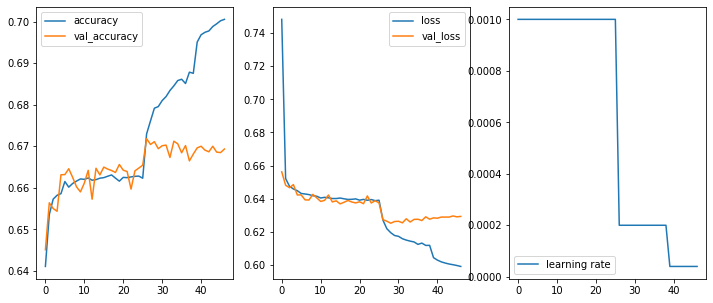

Epoch 48/10000
 76200/229427 [========>.....................] - ETA: 31s - loss: 0.5958 - accuracy: 0.7032

In [677]:
epochs = 10000
plot_progress = PlotProgress(entity=['loss','accuracy'])
adam = Adam(lr =.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=10,factor=.2, min_lr=0.000000001,verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

try:
    hist = model.fit(X_train, y_train,epochs=epochs, batch_size=200,validation_data=(X_test,y_test),callbacks=[plot_progress,reduce_lr])

except KeyboardInterrupt:
    
    pass

In [692]:
test_data["outcome"] = 0
X_validation = ct.transform(test_data[ordered_columns])

y_pred = model.predict_classes(X_validation)

op = lab_enc.inverse_transform(y_pred)
pd.DataFrame(op,columns=["outcome"]).to_csv("res2share.csv",index=False)

/home/prateek/.virtualenvs/cv_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
